In [1]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, csv
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
# df = pd.read_csv('AMD_2018-10-25_stock.csv', sep=';')
engine = create_engine('sqlite:///stock_base.db')
df = pd.read_sql_query('select formatted_date, close from tickers where tick="FB"', engine)
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df.ds)
df['y'] = np.log(df['y'])

In [3]:
train_df = df[:-20]
train_df

,ds,y
0,2012-05-18,3.643621
1,2012-05-21,3.527242
2,2012-05-22,3.433987
3,2012-05-23,3.465736
4,2012-05-24,3.497416
5,2012-05-25,3.462919
6,2012-05-29,3.361763
7,2012-05-30,3.338967
8,2012-05-31,3.387774
9,2012-06-01,3.322154


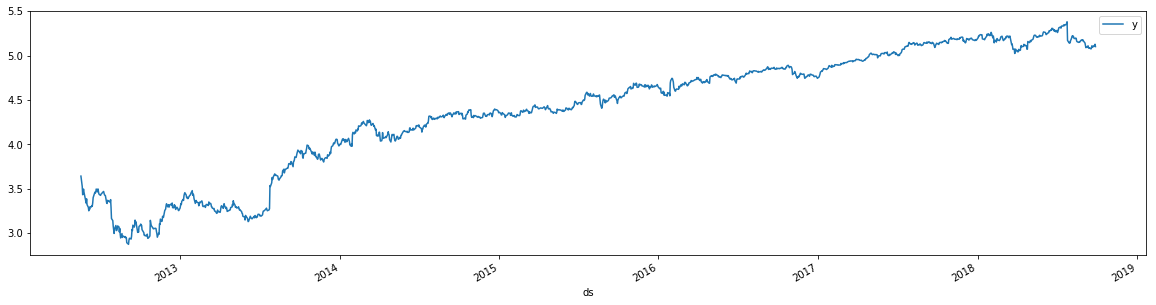

In [4]:
train_df.set_index('ds').plot(figsize=(20, 5))

In [5]:
%%time
m1 = Prophet(growth='linear', seasonality_mode='multiplicative', n_changepoints = 5, changepoint_prior_scale=0.01, changepoint_range = 1)
m1.fit(train_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2min 30s, sys: 3.51 s, total: 2min 33s
Wall time: 5min 21s


In [6]:
%%time
df_cv = cross_validation(m1, initial='1500 days', period='90 days', horizon = '50 days')

INFO:fbprophet.diagnostics:Making 9 forecasts with cutoffs between 2016-08-19 00:00:00 and 2018-08-09 00:00:00


CPU times: user 5min 26s, sys: 9.44 s, total: 5min 36s
Wall time: 11min 49s


In [7]:
df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p)

    horizon       mse      rmse       mae      mape  coverage
305 50 days  0.012816  0.113206  0.088269  0.017582  0.803922


In [8]:
#fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [9]:
n_forecast = 30
future1 = m1.make_future_dataframe(periods=n_forecast)

In [10]:
%%time
forecast1 = m1.predict(future1)

CPU times: user 3.81 s, sys: 90.2 ms, total: 3.9 s
Wall time: 5.04 s


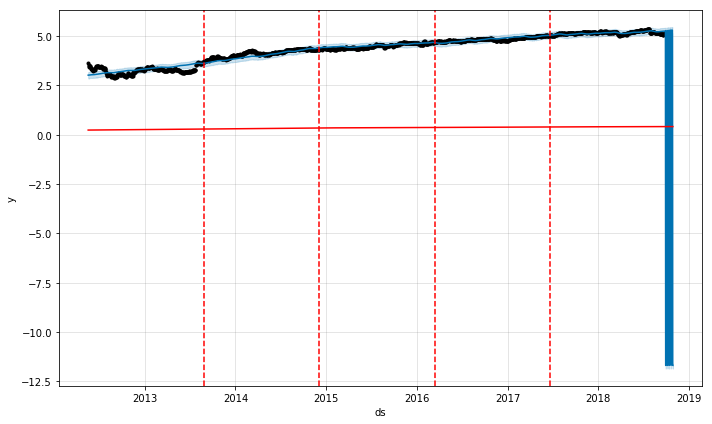

In [11]:
fig = m1.plot(forecast1)
a = add_changepoints_to_plot(fig.gca(), m1, forecast1)

In [12]:
forecast1 = forecast1[forecast1['ds'].dt.dayofweek < 5]

forecast1_norm = pd.concat([
        forecast1['ds'],
        np.exp(df['y']),
        np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']])
    ], axis=1)

In [13]:
forecast1_norm.tail(100)

,ds,y,yhat,yhat_lower,yhat_upper
1528,2018-06-15,195.850006,180.677357,155.893534,212.055750
1529,2018-06-18,198.309998,180.865591,154.004910,214.379227
1530,2018-06-19,197.490005,180.844791,153.131456,209.784470
1531,2018-06-20,202.000000,181.081444,155.749188,214.120204
1532,2018-06-21,201.500000,182.024190,154.558365,214.439670
1533,2018-06-22,201.740005,182.104940,156.774363,216.262299
1534,2018-06-25,196.350006,182.598661,153.952357,211.707113
1535,2018-06-26,199.000000,182.650918,154.168980,214.578481
1536,2018-06-27,195.839996,182.950000,155.200582,214.931816
1537,2018-06-28,196.229996,183.950838,157.575380,215.225546


Text(0.5, 1.0, 'Prophet forecast')

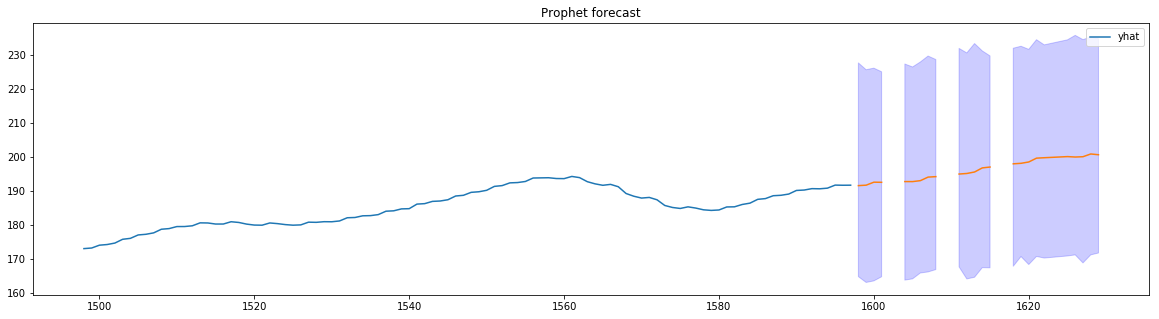

In [14]:
n_history = 100

forecast1_norm[-n_history-n_forecast:-n_forecast][['yhat']].plot(figsize=(20, 5))
plt.plot(forecast1_norm[-n_forecast:].index, forecast1_norm[-n_forecast:][['yhat']])
plt.fill_between(forecast1_norm[-n_forecast:].index, forecast1_norm[-n_forecast:]['yhat_lower'], forecast1_norm[-n_forecast:]['yhat_upper'], color='b', alpha=0.2)
plt.title('Prophet forecast')